https://app.jedha.co/course/regularization-and-hyperparameter-optimization-courses-pt/regularization-and-hyperparameter-optimization-template-pt

## Regularization and hyperparameter optimization with scikit-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score



In [13]:
# Import dataset
print("Loading dataset...")
data = pd.read_csv("OnlineNewsPopularity.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [14]:
data.columns = [name.strip() for name in data.columns]

In [15]:
data = data.sample(1000, random_state = 0)

<AxesSubplot:>

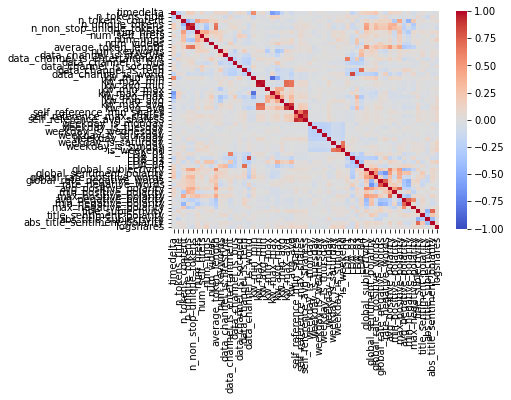

In [20]:
# Plot the heatmap and annotation on it
dataset_correlation = data.corr()
sns.heatmap(dataset_correlation, xticklabels=dataset_correlation.columns, yticklabels=dataset_correlation.columns, cmap='coolwarm', vmin=-1, vmax = 1)

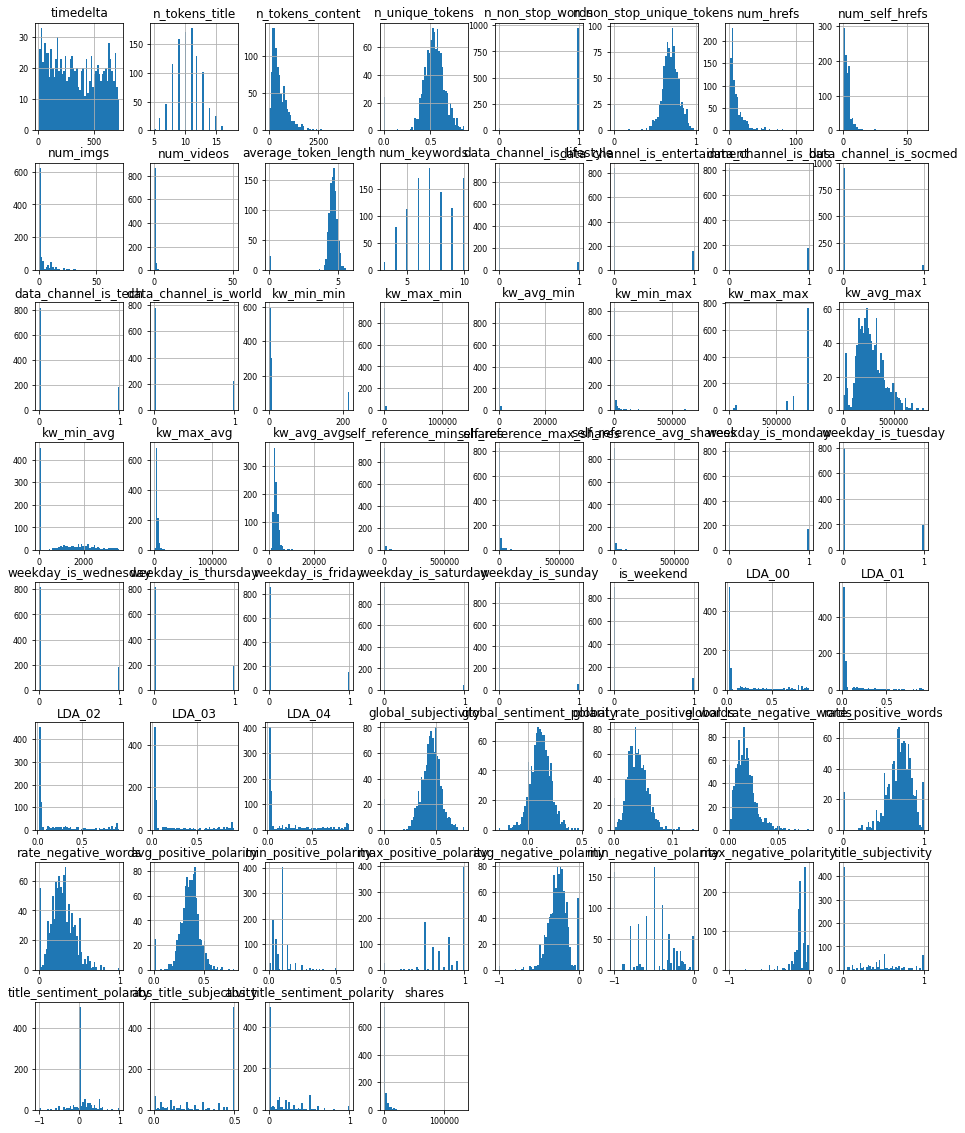

In [6]:
# listing dataframes types
list(set(data.dtypes.tolist()))
# include only float and integer
df_num = data.select_dtypes(include = ['float64', 'int64', 'UInt32'])
# display what has been selected
df_num.head()
# plot
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [16]:
# Drop some columns
useless_cols = ["url","LDA_00", "rate_positive_words", "n_non_stop_words"]


print("Dropping useless columns...")
data = data.drop(useless_cols, axis=1) # axis = 1 indicates that we are dropping along the column axis

print("...Done.")
print(data.head())

Dropping useless columns...
...Done.
       timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
18765      360.0             8.0             810.0         0.455696   
16349      415.0            12.0             122.0         0.678571   
27703      197.0            12.0             891.0         0.391455   
32947      113.0             9.0            1323.0         0.380952   
35434       75.0             8.0             261.0         0.596154   

       n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  \
18765                  0.623950       16.0             7.0       1.0   
16349                  0.783333        7.0             2.0       1.0   
27703                  0.483649        6.0             3.0      22.0   
32947                  0.530740       31.0            11.0      13.0   
35434                  0.721212        8.0             3.0       4.0   

       num_videos  average_token_length  ...  min_positive_polarity  \
18765         0.0              4

In [17]:
data = data.assign(logshares = lambda x: np.log(x['shares']))
data['logshares']

18765     6.823286
16349     7.377759
27703     9.367344
32947     9.798127
35434     8.665613
           ...    
24464     7.090077
1165      7.090077
22223    10.883692
17266     0.000000
937       7.901007
Name: logshares, Length: 1000, dtype: float64

In [18]:
print("Dropping shares...")
data = data.drop('shares', axis=1) # axis = 1 indicates that we are dropping along the column axis


Dropping shares...


In [19]:
foo = data.corr().abs()
pairs = foo.where(np.triu(foo, k=1).astype(bool)).stack()
list(pairs[pairs.abs().gt(0.9)].index)

[('n_unique_tokens', 'n_non_stop_unique_tokens'),
 ('kw_max_min', 'kw_avg_min'),
 ('self_reference_min_shares', 'self_reference_avg_sharess')]

In [21]:
# Drop some columns
useless_cols = ['n_unique_tokens', 'kw_max_min', 'self_reference_min_shares' ]


print("Dropping useless columns...")
data = data.drop(useless_cols, axis=1) # axis = 1 indicates that we are dropping along the column axis

print("...Done.")
print(data.head())

Dropping useless columns...
...Done.
       timedelta  n_tokens_title  n_tokens_content  n_non_stop_unique_tokens  \
18765      360.0             8.0             810.0                  0.623950   
16349      415.0            12.0             122.0                  0.783333   
27703      197.0            12.0             891.0                  0.483649   
32947      113.0             9.0            1323.0                  0.530740   
35434       75.0             8.0             261.0                  0.721212   

       num_hrefs  num_self_hrefs  num_imgs  num_videos  average_token_length  \
18765       16.0             7.0       1.0         0.0              4.943210   
16349        7.0             2.0       1.0         0.0              4.557377   
27703        6.0             3.0      22.0         2.0              4.712682   
32947       31.0            11.0      13.0         0.0              4.561602   
35434        8.0             3.0       4.0         0.0              4.601533   

 

In [25]:
# Separate target variable Y from features X
print("Separating labels from features...")
#features_list = ["Country", "Age", "Purchased"]
target_variable = "logshares"

X = data.iloc[:,:53]
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
18765    6.823286
16349    7.377759
27703    9.367344
32947    9.798127
35434    8.665613
Name: logshares, dtype: float64

X :
       timedelta  n_tokens_title  n_tokens_content  n_non_stop_unique_tokens  \
18765      360.0             8.0             810.0                  0.623950   
16349      415.0            12.0             122.0                  0.783333   
27703      197.0            12.0             891.0                  0.483649   
32947      113.0             9.0            1323.0                  0.530740   
35434       75.0             8.0             261.0                  0.721212   

       num_hrefs  num_self_hrefs  num_imgs  num_videos  average_token_length  \
18765       16.0             7.0       1.0         0.0              4.943210   
16349        7.0             2.0       1.0         0.0              4.557377   
27703        6.0             3.0      22.0         2.0              4.712682   
32947       31.0      

In [26]:
X.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_avg_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_max_shares', 'self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
 

In [27]:
# Automatically detect positions of numeric/categorical features
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity',

In [28]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, 
                                                    random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [29]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[ 1.15000000e+02  1.00000000e+01  2.32000000e+02  7.77777772e-01
   6.00000000e+00  5.00000000e+00  2.00000000e+00  0.00000000e+00
   4.58189655e+00  5.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  -1.00000000e+00  3.28800000e+02  2.20000000e+03  8.43300000e+05
   4.40080000e+05  1.90000000e+03  3.48422471e+03  2.69257871e+03
   7.80000000e+03  5.20000000e+03  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.01174197e-02  4.00083173e-02
   4.00005510e-02  8.39717826e-01  3.19365079e-01  1.74368687e-01
   3.87931034e-02  4.31034483e-03  1.00000000e-01  3.12836700e-01
   6.25000000e-02  7.00000000e-01 -2.50000000e-01 -2.50000000e-01
  -2.50000000e-01  0.00000000e+00  0.00000000e+00  5.00000000e-01
   0.00000000e+00]
 [ 1.07000000e+02  7.00000000e+00  2.16000000e+02  7.86324780e-01
   5

In [30]:
# Missing values
print("Imputing missing values...")
print(X_train[0:5,:])
print()
imputer = SimpleImputer(strategy="mean")
X_train[:,numeric_indices] = imputer.fit_transform(X_train[:,numeric_indices])
print("...Done!")
print(X_train[0:5,:]) 
print() 

Imputing missing values...
[[ 1.15000000e+02  1.00000000e+01  2.32000000e+02  7.77777772e-01
   6.00000000e+00  5.00000000e+00  2.00000000e+00  0.00000000e+00
   4.58189655e+00  5.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  -1.00000000e+00  3.28800000e+02  2.20000000e+03  8.43300000e+05
   4.40080000e+05  1.90000000e+03  3.48422471e+03  2.69257871e+03
   7.80000000e+03  5.20000000e+03  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.01174197e-02  4.00083173e-02
   4.00005510e-02  8.39717826e-01  3.19365079e-01  1.74368687e-01
   3.87931034e-02  4.31034483e-03  1.00000000e-01  3.12836700e-01
   6.25000000e-02  7.00000000e-01 -2.50000000e-01 -2.50000000e-01
  -2.50000000e-01  0.00000000e+00  0.00000000e+00  5.00000000e-01
   0.00000000e+00]
 [ 1.07000000e+02  7.00000000e+00  2.16000000e+02  7.86324780e-01
   5.00000000e+00  2.00000000e

In [31]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_train[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...

[[ 1.15000000e+02  1.00000000e+01  2.32000000e+02  7.77777772e-01
   6.00000000e+00  5.00000000e+00  2.00000000e+00  0.00000000e+00
   4.58189655e+00  5.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  -1.00000000e+00  3.28800000e+02  2.20000000e+03  8.43300000e+05
   4.40080000e+05  1.90000000e+03  3.48422471e+03  2.69257871e+03
   7.80000000e+03  5.20000000e+03  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.01174197e-02  4.00083173e-02
   4.00005510e-02  8.39717826e-01  3.19365079e-01  1.74368687e-01
   3.87931034e-02  4.31034483e-03  1.00000000e-01  3.12836700e-01
   6.25000000e-02  7.00000000e-01 -2.50000000e-01 -2.50000000e-01
  -2.50000000e-01  0.00000000e+00  0.00000000e+00  5.00000000e-01
   0.00000000e+00]
 [ 1.07000000e+02  7.00000000e+00  2.16000000e+02  7

In [35]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  -0.11617451888838819
The standard deviation is :  0.03929389703042956


In [34]:
# Perform grid search
print("Grid search...")
regressor = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0, 10, 10000] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 10000}
Best R2 score :  0.007665281436448586


In [38]:
gridsearch.cv_results_

{'mean_fit_time': array([0.03215726, 0.01909105, 0.01786709]),
 'std_fit_time': array([0.01247892, 0.00464564, 0.00436961]),
 'mean_score_time': array([0.00508293, 0.00524235, 0.00356205]),
 'std_score_time': array([0.00277419, 0.00064152, 0.00125586]),
 'param_alpha': masked_array(data=[0, 10, 10000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0}, {'alpha': 10}, {'alpha': 10000}],
 'split0_test_score': array([-0.20441507, -0.0733705 ,  0.01546025]),
 'split1_test_score': array([-0.08009332, -0.04840829,  0.00135119]),
 'split2_test_score': array([-0.10527223, -0.09031592,  0.00618441]),
 'mean_test_score': array([-0.12992687, -0.07069824,  0.00766528]),
 'std_test_score': array([0.05366478, 0.01721275, 0.00585441]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

In [36]:
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[7.43853291 7.4160016  7.59068671 7.5041983  7.45781846 7.49524435
 7.49360403 7.42696157 7.50023121 7.45576372 7.52752442 7.46095002
 7.4476471  7.52628257 7.50626878 7.42768581 7.54670832 7.44650758
 7.47050759 7.48518461 7.49808956 7.45368089 7.66774568 7.51205386
 7.4843285  7.44658631 7.44398032 7.48930323 7.45425183 7.48203222
 7.55507138 7.44695111 7.48667232 7.46775989 7.51042654 7.52149357
 7.46171092 7.53776973 7.45392574 7.48453171 7.45945407 7.52495179
 7.62516081 7.45328031 7.37407202 7.51360472 7.46320895 7.49626926
 7.45936296 7.49423124 7.50224722 7.47597011 7.55238883 7.49633929
 7.4907789  7.55920894 7.45993133 7.57062727 7.45763448 7.45510297
 7.59255696 7.49669919 7.61560936 7.44494311 7.48464485 7.47350666
 7.47663319 7.44556031 7.4834158  7.50807475 7.56309744 7.46483629
 7.47005984 7.4760041  7.49733893 7.50969053 7.4633235  7.56380165
 7.46576527 7.53900895 7.4739268  7.52698189 7.50057733 7.46845192
 7.50168667 7.51293446

## Test pipeline

In [39]:
# Missing values
print("Imputing missing values...")
print(X_test[0:5,:])
print()

X_test[:,numeric_indices] = imputer.transform(X_test[:,numeric_indices])
print("...Done!")
print(X_test[0:5,:]) 
print() 

Imputing missing values...
[[ 2.93000000e+02  7.00000000e+00  3.93000000e+02  7.44493389e-01
   9.00000000e+00  6.00000000e+00  1.00000000e+00  1.00000000e+00
   4.51653944e+00  8.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  -1.00000000e+00  3.02750000e+02  4.90000000e+03  8.43300000e+05
   1.50737500e+05  2.32600000e+03  4.08588136e+03  3.21032791e+03
   3.40000000e+03  2.90000000e+03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.50044911e-02  2.89618185e-01
   2.50006434e-02  6.35290809e-01  4.52523403e-01  1.56420431e-01
   5.08905852e-02  2.03562341e-02  2.85714286e-01  3.73214286e-01
   1.00000000e-01  1.00000000e+00 -1.61111111e-01 -2.50000000e-01
  -1.00000000e-01  0.00000000e+00  0.00000000e+00  5.00000000e-01
   0.00000000e+00]
 [ 3.16000000e+02  8.00000000e+00  1.03800000e+03  6.26229507e-01
   1.30000000e+01  7.00000000e

In [40]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_test[0:5,:])

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...

[[ 2.93000000e+02  7.00000000e+00  3.93000000e+02  7.44493389e-01
   9.00000000e+00  6.00000000e+00  1.00000000e+00  1.00000000e+00
   4.51653944e+00  8.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  -1.00000000e+00  3.02750000e+02  4.90000000e+03  8.43300000e+05
   1.50737500e+05  2.32600000e+03  4.08588136e+03  3.21032791e+03
   3.40000000e+03  2.90000000e+03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.50044911e-02  2.89618185e-01
   2.50006434e-02  6.35290809e-01  4.52523403e-01  1.56420431e-01
   5.08905852e-02  2.03562341e-02  2.85714286e-01  3.73214286e-01
   1.00000000e-01  1.00000000e+00 -1.61111111e-01 -2.50000000e-01
  -1.00000000e-01  0.00000000e+00  0.00000000e+00  5.00000000e-01
   0.00000000e+00]
 [ 3.16000000e+02  8.00000000e+00  1.03800000e+03  6

In [42]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[7.48968774 7.46461405 7.5772483  7.48915808 7.49434008 7.46217388
 7.44655578 7.45153522 7.47596995 7.46013518 7.59464488 7.46718769
 7.46826674 7.52708796 7.53977695 7.53298438 7.44533719 7.57210442
 7.54785126 7.48628689 7.5071466  7.53889827 7.47884896 7.57154158
 7.52288432 7.46404584 7.47258445 7.50432652 7.47789822 7.45964051
 7.55596391 7.47230183 7.48649376 7.4907204  7.44407487 7.44299214
 7.61894794 7.51675546 7.48552935 7.45788636 7.46677213 7.45413366
 7.43806357 7.49136195 7.46355634 7.46826459 7.46061968 7.49461834
 7.47051484 7.49828027 7.42975179 7.60872468 7.5630306  7.60880834
 7.57703202 7.4455205  7.50674067 7.47790608 7.51852364 7.50439208
 7.47745348 7.49432276 7.51294795 7.48269774 7.43029912 7.54099002
 7.51858416 7.52129996 7.5036519  7.41461198 7.51687331 7.48820892
 7.47632289 7.47930722 7.48982761 7.49202644 7.49251572 7.4497916
 7.47712805 7.91685202 7.47749649 7.48434682 7.47122605 7.5051753
 7.61979547 7.45663076 7.470

In [43]:
# Print R^2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.03313587201282542
R2 score on test set :  0.012610062310912884
